In [403]:
import torch
import math
import itertools
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

**Transition probabilites**

The state space is $s = (n_1 , n_2)$, where $n_i$ is the number of cars at i'th location. Let's work out the transition probabilities according to Poisson distributions described in the problem. For now we do not consider moving cars from one location to another, but simply work out probabilites for a transition from a state with $n$ cars to a state with $n'$ cars at one location.

The Poisson distributions for requests and returns are 

$$
p_{\lambda_{\text{req}}} (n_{\text{req}}) = {\lambda_{\text{req}}^{n_{\text{req}}} \over n_{\text{req}}!} \ e^{-\lambda_{\text{req}}} \ ,
\qquad
p_{\lambda_{\text{ret}}} (n_{\text{ret}}) = {\lambda_{\text{ret}}^{n_{\text{ret}}} \over n_{\text{ret}}!} \ e^{-\lambda_{\text{ret}}}
$$

To work out the transition probablilites $P_{n\to n'}$ it is convenient to split transitions into two steps:

$$n \quad \to \quad n - n_{\text{req}} \quad \to \quad n - n_{\text{req}} + n_{\text{ret}} = n'$$

The transition probabilities are

$$
\begin{align}
\nonumber
P_{n \to n'}^{(\text{inf})} &=
\sum_{n_{\text{req}}, n_{\text{ret}} = 0}^\infty p_{\lambda_{\text{req}}} (n_{\text{req}})p_{\lambda_{\text{ret}}} (n_{\text{ret}})
\left[ 
\theta(n_{\text{req}} \leq n-1) \delta_{n-n_{\text{req}}+n_{\text{ret}}, n'} + 
\theta(n_{\text{req}} \geq n) \delta_{n_{\text{ret}}, n'}
\right]
\\
&= \sum_{n_{\text{req}} = \max(0, n-n')}^{n-1} p_{\lambda_{\text{req}}} (n_{\text{req}})  p_{\lambda_{\text{ret}}} (n'-n + n_{\text{req}}) 
\quad + \quad 
\left( 1- \sum_{n_{\text{req}} = 0}^{n-1} p_{\lambda_{\text{req}}} (n_{\text{req}}) \right)  p_{\lambda_{\text{ret}}} (n')
\tag{1}
\end{align}
$$

The 2nd term accounts for the fact that if the number of requests is greater or equal than the number of available cars $n_{\text{req}} \geq n$, then we can only fulfill $n$ requests and the number of cars before returns is zero, such that $n' = n_{\text{ret}}$. In the first term in the LHS the sum starts at $n_{\text{req}} = \max(0, n-n')$. This is due to the fact that $n_{\text{ret}} = n'-n + n_{\text{req}} \geq 0 $, i.e. $n_{\text{req}} \geq n - n'$.

Note that above there is no restriction on $n,n'$. The superscript 'inf' in $P_{n \to n'}^{(\text{inf})}$ reminds us of that. If we're allowed only up to $n_{\text{max}}$ cars at a location, while extra cars are taken away, then transition probabilities are

$$
P_{n\to n'} = 
\begin{cases}
P_{n \to n'}^{(\text{inf})} \ , \qquad \qquad \qquad \quad \text{if} \quad 0 \leq n' \leq n_{\text{max}}-1 \\
1-\sum_{n'=0}^{ n_{\text{max}}-1} P_{n\to n'}^{(\text{inf})} \ , \qquad \text{if} \quad n' = n_{\text{max}}
\end{cases}
\tag{2}
$$

The probability $p(s'|s,a)$ of starting with $s = (n_1, n_2)$ cars at two locations, moving $a$ cars from 1st location to 2nd and ending up with $s' = (n_1', n_2')$ cars, is

$$
p(s'|s,a) = P_{n_1 - a \to n_1'} P_{n_2 + a \to n_2'} \tag{3}
$$

**Expected rewards**


The rewards depend only on the number of available cars and the number of requests. Suppose that we have $n$ cars at one location. Then the expected reward is

$$
R_n = \text{rent} \cdot \sum_{n_{\text{req}} = 0}^{n-1} n_{\text{req}} \ p_{\lambda_{\text{req}}} (n_{\text{req}})
+
\text{rent} \cdot n \left( 1- \sum_{n_{\text{req}} = 0}^{n-1} p_{\lambda_{\text{req}}} (n_{\text{req}}) \right)
\tag{4}
$$
where $\text{rent}$ is daily rent for a car. The second term takes into account that we can rent out at most $n$ cars even if there are many requests.

Now we take into account that there are two locations and we can move $a$ cars between them by paying $\text{cost}$ for each moved car. The full expected reward given a state $s = (n_1, n_2)$ and action $a$

$$\tag{5}
r(s, a) = R_{n_1 - a} + R_{n_2 + a} - \text{cost} \cdot |a|
$$


**Constraints on actions** 

The number of cars that can be moved are constrained by the number of available cars, maximum cars at each location $n_{\text{max}}$ and the maximum cars that can be moved at once $M$. Suppose we are in a state $s = (n_1, n_2)$. After moving $a$ cars we have $(n_1 - a, n_2 + a)$ cars. We must have

$$
0 \leq n_1 - a \leq n_{\text{max}} \ , \qquad 0 \leq n_2 + a \leq n_{\text{max}} \ , \qquad |a| \leq M
$$

This is equivalent to

$$\tag{6}
-\min(M, n_{\text{max}} - n_1, n_2) \leq a \leq \min(M, n_1, n_{\text{max}} - n_2)
$$


**Bellman equation**

The Bellman equation for our problem for the value function $v_{\pi}(s)$ given a deterministic policy $a = \pi(s)$, takes the form

$$
v_{\pi} (s) = r(s, \pi(s)) + \gamma \sum_{s'} p(s'|s,\pi(s)) v_{\pi}(s')
$$

Updates for policy evaluation and policy improvement are also straightforward to write down using function $p(s'|s,a), r(s,a)$ given in eqs. (3), (5).



In [404]:
class CarRental:

    def __init__(self, 
                rent = 10,          # rent per day per car
                cost = -2,           # moving cost per one car
                l_req_1 = 3,        # average car request per day
                l_req_2 = 4, 
                l_ret_1 = 3,        # average car return per day
                l_ret_2 = 2,
                n_max = 20,         # max cars at one location
                M = 5,              # max cars to move at once
                gamma = 0.9):
        
        self.rent = rent
        self.cost = cost

        self.l_req = (l_req_1, l_req_2)
        self.l_ret = (l_ret_1, l_ret_2)
        
        self.n_max = n_max
        self.M = M
        self.gamma = gamma

        # Precompute environment transition probabilites. List of two tensors, each of shape (n_max+1, n_max+1) and indexed by (np, n).
        self.P = [self._P(self.l_req[i], self.l_ret[i]) for i in range(2)]

        # Precompute expected rewards at two locations, eq. (4). This doesn't take into account action and moving costs. 
        self.R = [self._R(self.l_req[i]) for i in range(2)]

        # states are s = (n_1, n_2) - number of cars at 1st and 2nd locations
        # init value and policy
        self.v = torch.zeros((n_max + 1, n_max + 1), dtype = torch.float32)
        self.pi = torch.zeros((n_max + 1, n_max + 1), dtype = torch.long) # For a state (n_1, n_2) the policy pi is to move pi[n_1, n_2] cars from 1st location to 2nd. Negative number means move from 2nd to 1st.

        # Max and min number of cars that can be moved. See eq (6).
        self.pi_max = torch.minimum(
                            torch.arange(n_max+1).view(-1,1), 
                            20 - torch.arange(n_max+1).view(1,-1)
                            ).clamp(max = M)
        self.pi_min = - self.pi_max.T

    #-----------------------------------------------------
    
    @staticmethod
    def poisson(x, n):
        x = torch.tensor(x, dtype = torch.float32)
        return torch.exp(-x) * x**n / math.factorial(n)

    #-----Transition probabilites------------------------------------------------

    # Eq (1)
    def _P_inf(self, np, n, l_req, l_ret):
        '''
        Transition probabilities at one location (without restriction n,np <= n_max):

            n  - initial number of cars
            np - final number of cars
            l_req - average requests
            l_ret - average returns
        '''

        return sum( self.poisson(l_req, n_req) * self.poisson(l_ret, np - n + n_req) for n_req in range(max(0, n-np), n) ) \
               - ( 1 - sum( self.poisson(l_req, n_req) for n_req in range(0, n) ) ) * self.poisson(l_ret, np)

    # Eq (2)
    def _P(self, l_req, l_ret):
        '''
        Transition probabilities at one location (with restriction np,n <= n_max).
        Returns tensor of shape (n_max+1, n_max+1) index by (np, n); 0<= np,n <= n_max

            n  - initial number of cars
            np - final number of cars
            l_req - average requests
            l_ret - average returns
        '''
        
        # indexed by (np, n), size (n_max, n_max+1)
        out = torch.tensor([[self._P_inf(np, n, l_req, l_ret) for n in range(self.n_max+1)] for np in range(self.n_max)]) 
        # probability to end up with n_max cars is 1 minus everything else
        p_max = (1 - out.sum(dim=0)).view(1,-1)
        out = torch.cat([out, p_max], dim = 0) 
        
        return out
        
    # Eq (3)
    def p(self, s, a):
        '''
        Transition probability p(sp|s, a).
        Returns tensor of shape (n_max + 1, n_max + 1) indexed by sp = (np1, np2).
        '''
        return self.P[0][:, s[0]-a].view(-1,1) * self.P[1][:, s[1]+a].view(1,-1)


    #------Expected rewards-----------------------------------------------

    # Eq (4)
    def _R(self, l_req):
        ''' 
        Returns tensor of shape (n_max + 1,) indexed by n.
        '''
        return torch.tensor([self.rent * sum( (n_req - n) * self.poisson(l_req, n_req) for n_req in range(n)) 
                             + self.rent * n 
                             for n in range(self.n_max + 1) ], 
                             dtype = torch.float32)
    
    # Eq (5)
    def r(self, s, a):
        ''' 
        Full expected reward r(s, a).
        Returns (1,) tensor.
        '''
        return self.R[0][s[0]-a] + self.R[1][s[1]+a] + self.cost * abs(a)
    
    
    #------Policy evaluation-----------------------------------------------

 
    def policy_eval(self, v_in, pi, theta = 1e-2):
        '''
        Iterative policy evaluation. 
        Returns value function v(s) for policy pi.
        v_in  - initial value function, (n_max+1,n_max+1) tensor indexed by s = (n1, n2).
        theta - convergence tolerance 
        '''
        
        v = v_in.clone()

        while True:
            delta = 0
    
            for s in itertools.product(range(self.n_max+1), range(self.n_max+1)):
                a = pi[s].item()
                v_old = v[s].clone() # important to clone v[s], otherwise v_old refers to the same element and delta = 0 below
                v[s] = self.r(s, a) + self.gamma * torch.sum(self.p(s, a) * v)
                delta = max(delta, abs(v_old - v[s]))
            
         
            if delta < theta:
                break
        
        return v

    #------Greedy policy for a given value function---------------------------------------------

    def greedy_policy(self, v, pi_in):
        policy_stable = True
        pi = pi_in.clone()
        
        for s in itertools.product(range(self.n_max+1), range(self.n_max+1)):
            a_old = pi[s].clone()
            
            # q(s,a)
            q = [ (self.r(s,a) + self.gamma * torch.sum(self.p(s, a) * v)) for a in range(self.pi_min[s], self.pi_max[s]+1) ]
            pi[s] = self.pi_min[s] + q.index(max(q))

            if a_old != pi[s]:
                policy_stable = False

        return pi, policy_stable



    #------Policy iteration-----------------------------------------------


    def policy_iter(self):
        v = self.v.clone()
        pi = self.pi.clone()

        values = []
        policies = []

        progress_bar = tqdm()
        i = 0
        while True:
            v = self.policy_eval(v, pi)
            pi, policy_stable = self.greedy_policy(v, pi)
            

            i += 1
            progress_bar.update(1)

            if policy_stable:
                break

            values.append(v)
            policies.append(pi)
        
        self.v_opt = values[-1]
        self.pi_opt = policies[-1]

        return values, policies
    


    #------Plot optimal policy and value heatmaps-----------------------------------------------


    @staticmethod
    def heat_plot(tensor, title = None, xlabel = None, ylabel = None):
        
        plt.imshow(tensor)
        plt.colorbar()
        plt.gca().invert_yaxis()
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.show()

    def plot_optimal(self):
        
        self.heat_plot(self.pi_opt, 'Optimal Policy', '# Cars at 2nd location', '# Cars at 1st location')
        self.heat_plot(self.v_opt, 'Optimal Value Function', '# Cars at 2nd location', '# Cars at 1st location')


Now we run policy iteration algorithm

In [405]:
C = CarRental()
values, policies = C.policy_iter()

0it [00:00, ?it/s]

And plot optimal results for the policy and value function

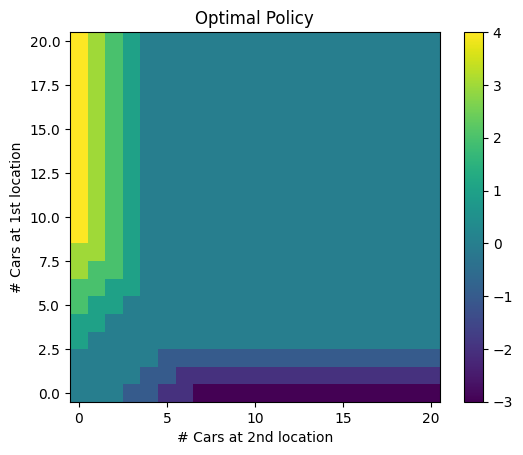

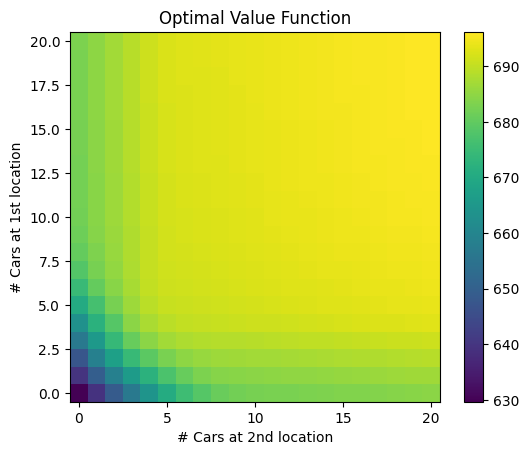

In [406]:
C.plot_optimal()

These are very similar to the figure 4.2 in Sutton-Barto (see above), but are not quite the same. For example, the optimal number of cars to move for (20,0) cars at two locations is 4 in my plots, while it is 5 in Sutton-Barto. 

For comparison, plot max and min allowed values for the number of moved cars.

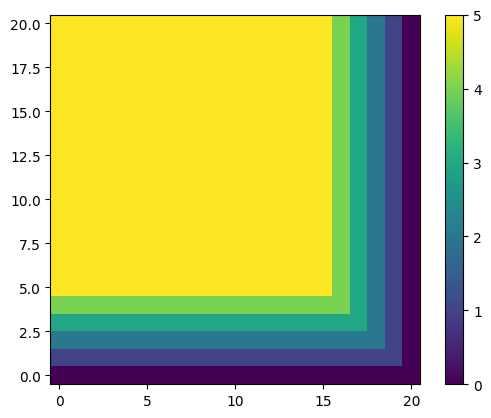

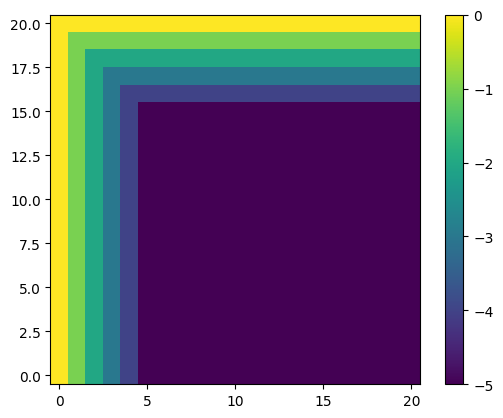

In [407]:
C.heat_plot(C.pi_max)
C.heat_plot(C.pi_min)

**Now let's solve the Car Rental problem with modifications from Exercise 4.7**

In [408]:
class CarRentalVariant(CarRental):

    def __init__(self,
                max_parked_cars = 10,  # max number of cars parked at one location
                extra_park_cost = -4,   # cost of parking more than max_parked_cars
                free_rides = 1         # number of cars that can be shuttled between two locations for free)
                ):

        super().__init__()

        self.max_parked_cars = max_parked_cars
        self.extra_park_cost = extra_park_cost
        self.free_rides = free_rides


    # The only part we change is to overwrite expected rewards
    def r(self, s, a):
        ''' 
        Full expected reward r(s, a).
        Returns (1,) tensor.
        '''
        overflow_locations = (s[0]-a > self.max_parked_cars) + (s[1]+a > self.max_parked_cars) # number of locations with overflow
        
        return self.R[0][s[0]-a] + self.R[1][s[1]+a] + self.cost * (abs(a) - self.free_rides) + overflow_locations * self.extra_park_cost
    

In [409]:
C_var = CarRentalVariant()
values, policies = C_var.policy_iter()

0it [00:00, ?it/s]

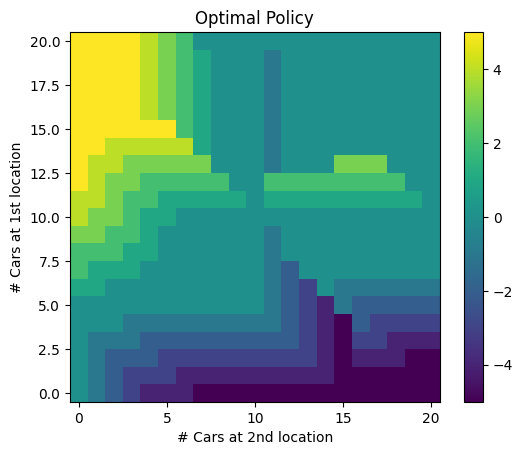

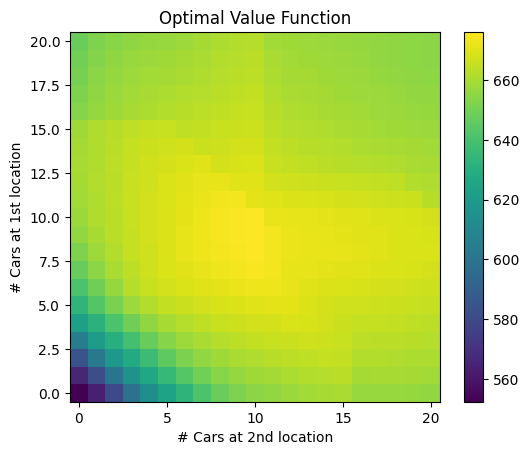

In [410]:
C_var.plot_optimal()